In [240]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.sparse
pd.set_option("display.max_columns",101)
RANDOM_STATE = 42
DATA_PATH = "../data/instacart/"

In [242]:
print('loading prior')
priors = pd.read_csv(DATA_PATH + 'order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})


print('loading orders')
orders = pd.read_csv(DATA_PATH + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})
orders.set_index('order_id', inplace=True, drop=False)

print('loading train')
train = pd.read_csv(DATA_PATH + 'order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('add order info to priors')
orders.set_index('order_id', inplace=True, drop=False)
priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)

print ('split orders: train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

loading prior
loading orders
loading train
add order info to priors
split orders: train, test


In [244]:
users = pd.read_csv(DATA_PATH + "users_match.csv", dtype={
    'total_items': np.int32,
    'total_distinct_items': np.int32,
    'average_days_between_orders': np.float32,
    'nb_orders': np.int32,
    'average_basket': np.float32
})
users.set_index('user_id', inplace=True)
def xx(a):
    tmp = a.strip()[5:-2].split(",")
    result = [int(x) for x in tmp if x]
    return result
users['all_products'] = users['all_products'].apply(xx)

products = pd.read_csv(DATA_PATH + "products_match.csv", dtype={
    'product_id': np.int32,
    'aisle_id': np.int32,
    'department_id': np.int32,
    'orders': np.float32,
    'reorders': np.float32,
    'reorder_rate': np.float64
})

products.set_index('product_id.1', inplace=True)

userXproduct = pd.read_csv(DATA_PATH + "user_product_match.csv", index_col=0, dtype={
    'np_orders': np.int32,
    'last_order_id': np.int32,
    'sum_pos_in_cart': np.float32,
})

In [245]:
def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%10000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        if user_id not in users.all_products:
            continue
            
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    df.head()
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('order related features')
    df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders)
    df['product_reorders'] = df.product_id.map(products.reordered)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x))

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)

In [246]:
df_train, labels = features(train_orders, labels_given=True)

f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last', 'dow']

build candidate list
('order row', 10000)
('order row', 20000)
('order row', 30000)
('order row', 40000)
('order row', 50000)
('order row', 60000)
('order row', 70000)
('order row', 80000)
('order row', 90000)
('order row', 100000)
('order row', 110000)
('order row', 120000)
('order row', 130000)
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int32
user_total_items                      int32
total_distinct_items                  int32
user_average_days_between_orders    float32
user_average_basket                 float32
dow                                    int8
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              int32
department_id                         int32
product_orders              

In [247]:
m = int(len(labels) * 0.8)
df_train_data = df_train[:m]
label_train = labels[:m]

In [248]:
df_test_dat = df_train[m:]
label_test = labels[m:]

In [249]:
import lightgbm as lgb
d_train = lgb.Dataset(df_train_data[f_to_use],
                      label=label_train,
                      categorical_feature=['aisle_id', 'department_id']) 
d_test = lgb.Dataset(df_test_dat[f_to_use],
                      label=label_test,
                      categorical_feature=['aisle_id', 'department_id'])

In [290]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'learning_rate': 0.1,
    'min_child_samples': 50,
    'reg_lambda': 0.7,
    'n_estimators': 400,
    'silent': True
}

print('light GBM train :-)')
clf = lgb.LGBMClassifier(**params)
result = clf.fit(df_train_data[f_to_use], label_train, 
        eval_set=[(df_test_dat[f_to_use], label_test),], 
        eval_metric=['auc',], 
        categorical_feature=['aisle_id', 'department_id'], 
        early_stopping_rounds=10,
        )

light GBM train :-)
[1]	valid_0's auc: 0.816892
Train until valid scores didn't improve in 10 rounds.
[2]	valid_0's auc: 0.816491
[3]	valid_0's auc: 0.821738
[4]	valid_0's auc: 0.819281
[5]	valid_0's auc: 0.822138
[6]	valid_0's auc: 0.823342
[7]	valid_0's auc: 0.823945
[8]	valid_0's auc: 0.824461
[9]	valid_0's auc: 0.824858
[10]	valid_0's auc: 0.825009
[11]	valid_0's auc: 0.825225
[12]	valid_0's auc: 0.825482
[13]	valid_0's auc: 0.825394
[14]	valid_0's auc: 0.825731
[15]	valid_0's auc: 0.825912
[16]	valid_0's auc: 0.826038
[17]	valid_0's auc: 0.826137
[18]	valid_0's auc: 0.826161
[19]	valid_0's auc: 0.826413
[20]	valid_0's auc: 0.826587
[21]	valid_0's auc: 0.826765
[22]	valid_0's auc: 0.82691
[23]	valid_0's auc: 0.827031
[24]	valid_0's auc: 0.827177
[25]	valid_0's auc: 0.827311
[26]	valid_0's auc: 0.827391
[27]	valid_0's auc: 0.827561
[28]	valid_0's auc: 0.827718
[29]	valid_0's auc: 0.827839
[30]	valid_0's auc: 0.827952
[31]	valid_0's auc: 0.828006
[32]	valid_0's auc: 0.82813
[33]	vali

#### GridSearch

In [288]:
from sklearn.model_selection import GridSearchCV
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'min_child_samples': 50,
    'reg_lambda': 0.7,
    'silent': True
}

fit_params= {
    "eval_set": [(df_test_dat[f_to_use], label_test),], 
    "eval_metric": ['auc',], 
    "categorical_feature" : ['aisle_id', 'department_id'], 
    "early_stopping_rounds": 10,
}

clf = lgb.LGBMClassifier(**params)
grid_param = {
    'learning_rate': [0.01, 0.03, 0.09, 0.27, 0.81],
    'n_estimators': [50, 100],
}
gv = GridSearchCV(clf, grid_param, fit_params=fit_params)
gv.fit(df_train_data[f_to_use], label_train)

[1]	valid_0's auc: 0.817057
Train until valid scores didn't improve in 10 rounds.
[2]	valid_0's auc: 0.815643
[3]	valid_0's auc: 0.820112
[4]	valid_0's auc: 0.817234
[5]	valid_0's auc: 0.819491
[6]	valid_0's auc: 0.820462
[7]	valid_0's auc: 0.821073
[8]	valid_0's auc: 0.821574
[9]	valid_0's auc: 0.82177
[10]	valid_0's auc: 0.822024
[11]	valid_0's auc: 0.82215
[12]	valid_0's auc: 0.822216
[13]	valid_0's auc: 0.822085
[14]	valid_0's auc: 0.82238
[15]	valid_0's auc: 0.822545
[16]	valid_0's auc: 0.822809
[17]	valid_0's auc: 0.822841
[18]	valid_0's auc: 0.822704
[19]	valid_0's auc: 0.822765
[20]	valid_0's auc: 0.82284
[21]	valid_0's auc: 0.822916
[22]	valid_0's auc: 0.822968
[23]	valid_0's auc: 0.822996
[24]	valid_0's auc: 0.823031
[25]	valid_0's auc: 0.823042
[26]	valid_0's auc: 0.822991
[27]	valid_0's auc: 0.823165
[28]	valid_0's auc: 0.823321
[29]	valid_0's auc: 0.823349
[30]	valid_0's auc: 0.823375
[31]	valid_0's auc: 0.82331
[32]	valid_0's auc: 0.823351
[33]	valid_0's auc: 0.823364
[34

KeyboardInterrupt: 

In [ ]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'learning_rate': 0.05,
    'min_data_in_leaf': 50,
    'lambda_l2': 0.7,
    'num_boost_round'： 400，
}

print('light GBM train :-)')

import copy
def grid_search(params):
    range_key_list = [key for value in params.values if isinstance(value, list)]
    param_tuple_list = make_tuple_list(params, range_key_list)
    
    metric = params['metric']
    best_score = 0
    best_param = None
    
    for key in range_key_list:
        del params[key]
    
    i = 0
    for value_tuple in param_tuple_list:
        i += 0
        print "round: %d/%d", % (i, len(param_tuple_list))
        
        for i in xrange(len(value_tuple)):
            params[range_key_list[i]] = value_tuple[i]
        
        bst = lgb.train(params, d_train, valid_sets=[d_test,], early_stopping_rounds=10, silent=False)
        current_score = bst.best_score['valid_0'][metric]
        if current_score > best_score:
            best_score = current_score
            best_param = copy.deepcopy(params)
    
    print "best_score\n", best_score
    print "best_params\n", best_param

In [251]:
bst.best_iteration

380

In [265]:
bst.best_score['valid_0']['auc']

0.83266276922467375

In [291]:
lgb.plot_importance(bst, figsize=(9,20))

AttributeError: 'LGBMClassifier' object has no attribute 'plot_importance'

In [298]:
preduct_result

array([[ 0.95245443,  0.04754557],
       [ 0.08424724,  0.91575276],
       [ 0.87778436,  0.12221564],
       ..., 
       [ 0.79999116,  0.20000884],
       [ 0.99344665,  0.00655335],
       [ 0.99354096,  0.00645904]])

In [302]:
preduct_result =clf.predict_proba(df_train_data[f_to_use], num_iteration=clf.best_iteration)[:, 1
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(label_train, preduct_result])
metrics.auc(fpr, tpr)

0.84117944987273663

#### 分析错误数据和真实数据的区别，增加新的特征数据

In [90]:
result = preduct_result > 0.22
wrong_index = result != label_test
right_index = result == label_test

In [106]:
right_test_data = df_test_dat[right_index]
right_test_label = label_test[right_index]
wrong_test_data = df_test_dat[wrong_index]
wrong_test_label = label_test[wrong_index]

In [92]:
right_test_data.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,dow,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
6779728,769244,6375,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,3,19,817.0,547.0,0.669523,1,0.014286,19.000000,0.014286,69,3
6779729,769244,8174,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,24,4,42721.0,27332.0,0.639779,1,0.014286,21.000000,0.014286,66,3
6779730,769244,24810,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,78,19,8357.0,4654.0,0.556898,6,0.085714,9.166667,0.085714,16,1
6779731,769244,46631,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,94,7,284.0,134.0,0.471831,4,0.057143,13.250000,0.057143,11,5
6779732,769244,41198,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,88,13,3828.0,1618.0,0.422675,8,0.114286,15.000000,0.114286,27,2


In [93]:
wrong_test_data.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,dow,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
6779747,769244,33037,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,93,3,4199.0,2813.0,0.669921,22,0.314286,11.272727,0.314286,3,7
6779761,769244,19677,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,91,16,14712.0,10927.0,0.742727,15,0.214286,10.200000,0.214286,4,5
6779828,769244,33754,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,120,16,29893.0,22419.0,0.749975,12,0.171429,8.166667,0.171429,3,7
6779843,2492692,24964,9,39,29,26.375000,4.333333,1,9,30.0,1.137441,83,4,109778.0,74663.0,0.680127,3,0.333333,4.333333,0.333333,1,5
6779844,2492692,14218,9,39,29,26.375000,4.333333,1,9,30.0,1.137441,86,16,8568.0,6238.0,0.728058,2,0.222222,1.500000,0.222222,1,5


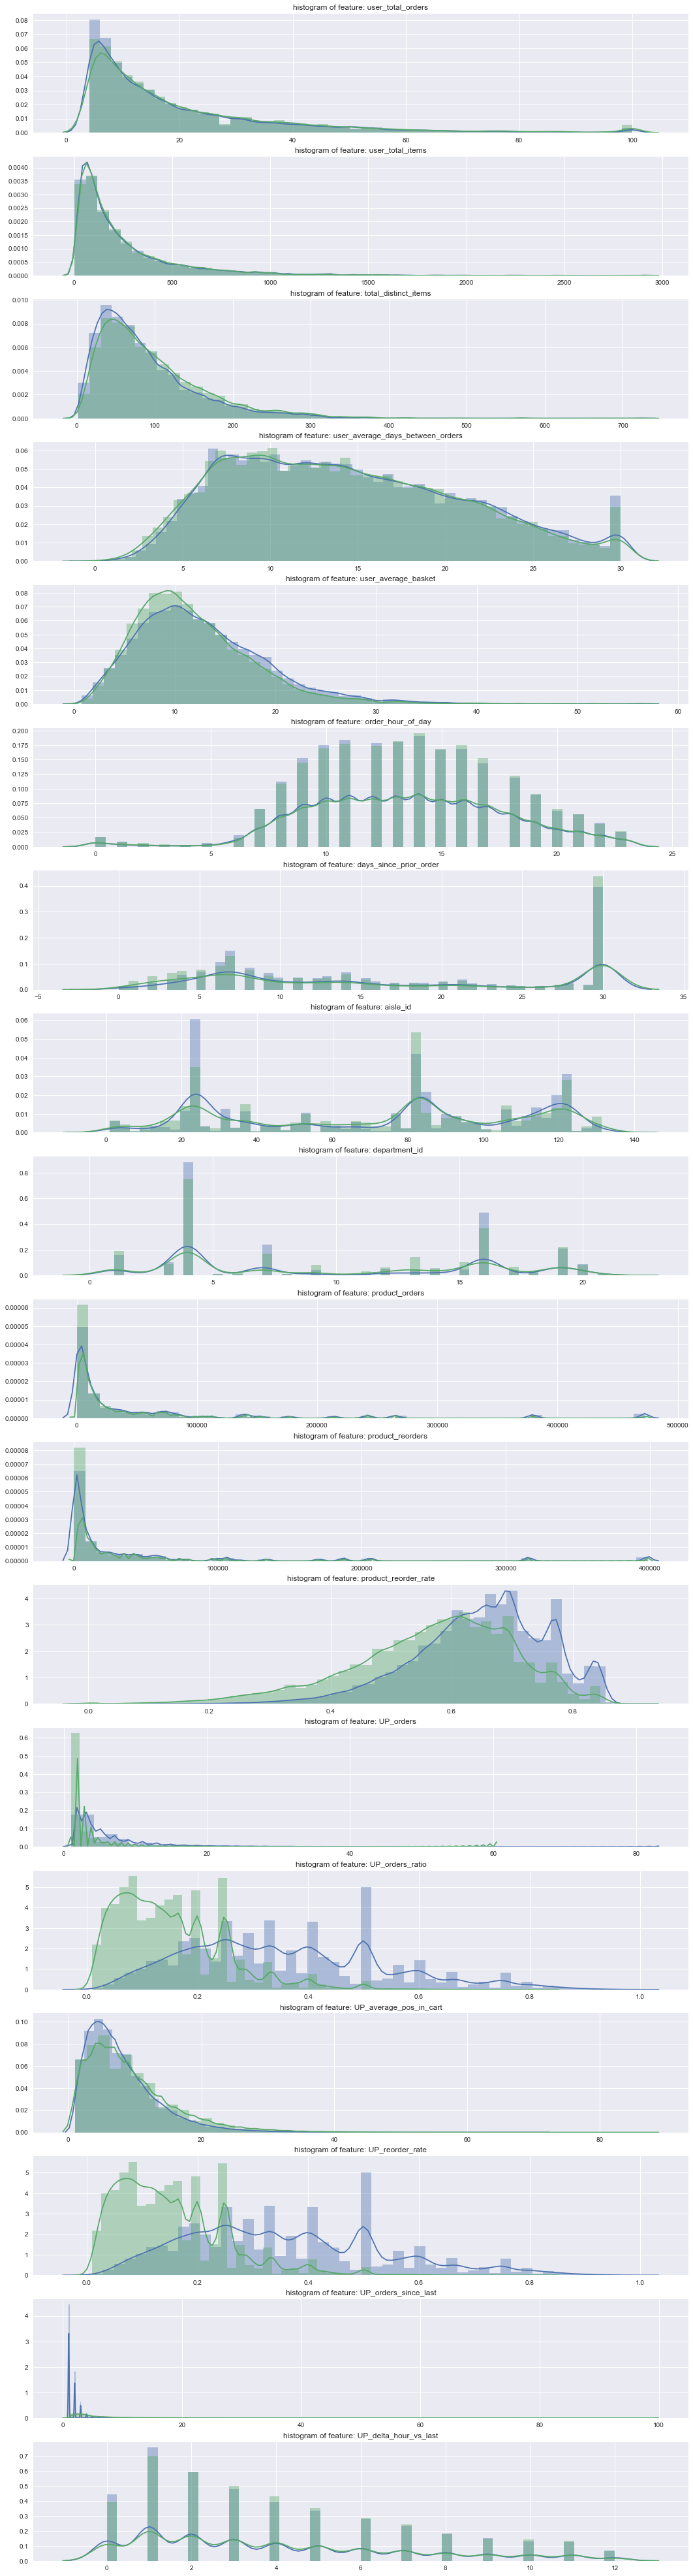

In [112]:
import matplotlib.gridspec as gridspec
import seaborn as sns
v_features = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last']
plt.figure(figsize=(len(v_features),28*4))
gs = gridspec.GridSpec(28, 1)

for i, cn in enumerate(df_test_dat[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df_test_dat[cn][wrong_index][wrong_test_label == 0], bins=50)
    sns.distplot(df_test_dat[cn][wrong_index][wrong_test_label == 1], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

#### 由上图UP_reorder_rate\UP_order_ratio\UP_orders数据较低的时候，即重购率低、购买次数低以及总共订单数较少时，容易误判为不购买。这些数据最好进行细分。先把UP_order_ratio过低的放到第一个模型

In [308]:
max_i = None
max_f = 0
preduct_result =clf.predict_proba(df_test_dat[f_to_use], num_iteration=clf.best_iteration)[:, 1]
from sklearn.metrics import f1_score
for i in range(1, 100, 1):
    result = preduct_result > i / 100.0
    xx = f1_score(label_test, result)
    if xx > max_f:
        max_f = xx
        max_i = i
    print i, xx
    
print "max_i", max_i, max_f

1 0.198038835453
2 0.228781501866
3 0.25613561285
4 0.279841434872
5 0.301195706499
6 0.320332064467
7 0.337319688097
8 0.352766189975
9 0.366668484078
10 0.378935597292
11 0.389900666316
12 0.399631285847
13 0.407825672605
14 0.414926807245
15 0.421138918968
16 0.425923183359
17 0.430046952502
18 0.433186163085
19 0.435826579995
20 0.437725676411
21 0.438716944423
22 0.439156000286
23 0.438650264887
24 0.438343140674
25 0.437132948379
26 0.434852080178
27 0.432205389011
28 0.428635701499
29 0.425053142933
30 0.421073865008
31 0.416807177924
32 0.411883492724
33 0.406233177504
34 0.400536885557
35 0.394726151346
36 0.388372943603
37 0.381468476334
38 0.374263134156
39 0.366665601227
40 0.359551110027
41 0.352351102364
42 0.34420087215
43 0.335769603718
44 0.328012907815
45 0.31953611039
46 0.310444692737
47 0.301788264092
48 0.293546875431
49 0.284901981769
50 0.276633735201
51 0.268521918259
52 0.259170238233
53 0.250308748944
54 0.240914497811
55 0.232048276894
56 0.222988158226
57 0

In [305]:
df_test, _ = features(test_orders)

build candidate list
('order row', 10000)
('order row', 20000)
('order row', 30000)
('order row', 40000)
('order row', 50000)
('order row', 60000)
('order row', 70000)
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int32
user_total_items                      int32
total_distinct_items                  int32
user_average_days_between_orders    float32
user_average_basket                 float32
dow                                    int8
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              int32
department_id                         int32
product_orders                      float32
product_reorders                    float64
product_reorder_rate                float64
UP_orders                 

In [309]:
print('light GBM predict')
preds = clf.predict_proba(df_test[f_to_use], num_iteration=clf.best_iteration)[:, 1]

light GBM predict


In [310]:
result_pred = preds > 0.22
sum(result_pred)

605636

In [311]:
df_test['pred'] = preds

TRESHOLD = max_i/100.0  # guess, should be tuned with crossval on a subset of train data

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv(DATA_PATH + 'sub.csv', index=False)